# Lane Detection 

Source : [DeepPiCar](#https://towardsdatascience.com/deeppicar-part-1-102e03c83f2c)
<br/>
Lane Detection : [auto steering](#https://towardsdatascience.com/deeppicar-part-4-lane-following-via-opencv-737dd9e47c96) 
<br/>
Github : [Full Code for reference](#https://github.com/dctian/DeepPiCar/tree/master/driver/code)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging
import math

In [2]:
def showImage(image, title): 
    plt.figure()
    plt.title(title)
    plt.imshow(image)
        plt.xticks([]), plt.yticks([])

def showImageBGR(image, title):
    showImage(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), title)


Take image and transform it to HSV

(([], []), ([], []))

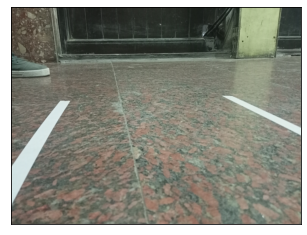

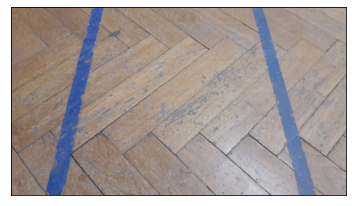

In [3]:
frame = cv2.imread("lane6.jpg")
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

frameBlue = cv2.imread("laneBlue1.jpg")
hsvBlue = cv2.cvtColor(frameBlue, cv2.COLOR_BGR2HSV)

plt.figure()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])


plt.figure()
plt.imshow(cv2.cvtColor(frameBlue, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

Filter the track color (White or Blue) only from the frame using Mask

(([], []), ([], []))

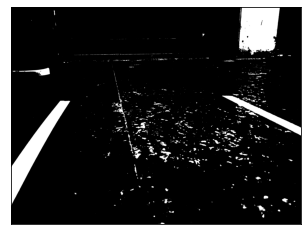

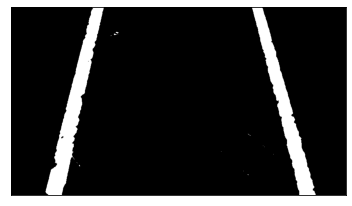

In [4]:
#range of white in HSV
lowerWhite = np.array([0,0,168])
upperWhite = np.array([172,111,255])

# Range of Blue in HSV
lowerBlue = np.array([60,40,40])
upperBlue = np.array([150,255,255])

# Threshold the HSV image to get only the white
mask = cv2.inRange(hsv, lowerWhite, upperWhite)
# Bitwise-AND mask and original image
res = cv2.bitwise_and(frame, frame, mask= mask)

# Threshold the HSV image to get only the Blue
maskBlue = cv2.inRange(hsvBlue, lowerBlue, upperBlue)

plt.figure()
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

plt.figure()
plt.imshow(cv2.cvtColor(maskBlue, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

# Detecting Edges of lane

(([], []), ([], []))

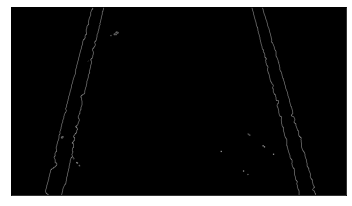

In [5]:
edges = cv2.Canny(maskBlue, 200, 400)

plt.figure()
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

## Create Detect edges function 

In [6]:
def detectEdges(frame, lowerColor, upperColor):
    # Transform into HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    showImageBGR(frame, "Image")
    showImageBGR(hsv, "HSV")

    # Threshold the HSV image to get only the white
    mask = cv2.inRange(hsv, lowerColor, upperColor)
    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame, frame, mask= mask)
    showImageBGR(mask, "Mask")

    # Detect edges
    edges = cv2.Canny(mask, 200, 400)

    return edges

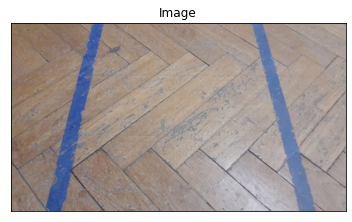

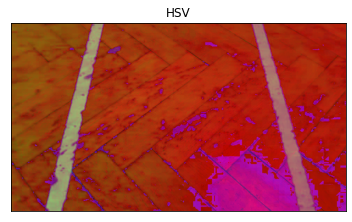

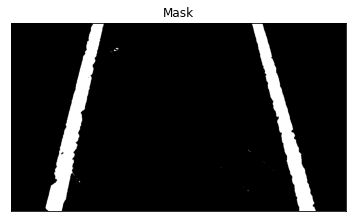

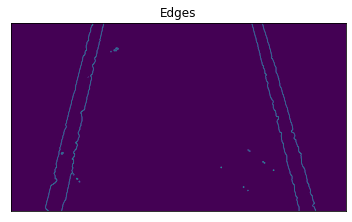

In [7]:
edges = detectEdges(frameBlue, lowerBlue, upperBlue)
showImage(edges, "Edges")

## Isolate region of interest

(NOT Necessery)

In [8]:
def regionOfInterest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # only focus bottom half of the screen
    polygon = np.array([[
        (0, height * 1 / 2),
        (width, height * 1 / 2),
        (width, height),
        (0, height),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    croppedEdges = cv2.bitwise_and(edges, mask)
    return croppedEdges

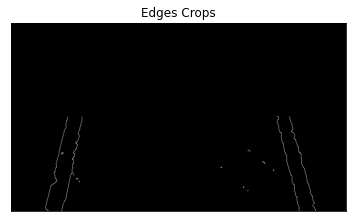

In [9]:
croppedEdges = regionOfInterest(edges)
showImageBGR(croppedEdges, "Edges Crops")

## Detect Line Segments

Using Hough Transform

In [10]:
def detectLineSegments(croppedEdges):
    # tuning minThreshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # distance precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
    minThreshold = 10  # minimal of votes
    lineSegments = cv2.HoughLinesP(croppedEdges, rho, angle, minThreshold, np.array([]), minLineLength=8, maxLineGap=4)

    return lineSegments

In [11]:
lineSegments = detectLineSegments(edges)
# lineSegments = detectLineSegments(croppedEdges)

## Combine Line Segments into two lanes

all line segments belonging to the left lane line should be upward sloping and on the left side of the screen, whereas all line segments belonging to the right lane line should be downward sloping and be on the right side of the screen. Once the line segments are classified into two groups, we just take the average of the slopes and intercepts of the line segments to get the slopes and intercepts of left and right lane lines.

In [12]:
def averageSlopeIntercept(frame, lineSegments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    laneLines = []
    if lineSegments is None:
        logging.info('No lineSegment segments detected')
        return laneLines

    height, width, _ = frame.shape
    leftFit = []
    rightFit = []

    boundary = 1/3
    leftRegionBoundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    rightRegionBoundary = width * boundary # right lane line segment should be on right 2/3 of the screen

    for lineSegment in lineSegments:
        for x1, y1, x2, y2 in lineSegment:
            if x1 == x2:
                logging.info('skipping vertical line segment (slope=inf): %s' % lineSegment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1) # Least squares polynomial fit of the first degree.
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < leftRegionBoundary and x2 < leftRegionBoundary:
                    leftFit.append((slope, intercept))
            else:
                if x1 > rightRegionBoundary and x2 > rightRegionBoundary:
                    rightFit.append((slope, intercept))

    leftFitAverage = np.average(leftFit, axis=0)
    if len(leftFit) > 0:
        laneLines.append(makePoints(frame, leftFitAverage))

    rightFitAverage = np.average(rightFit, axis=0)
    if len(rightFit) > 0:
        laneLines.append(makePoints(frame, rightFitAverage))

    logging.debug('lane lines: %s' % laneLines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return laneLines

Take line slope and intercept and retrun the endpoints of the line

In [13]:
def makePoints(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

## Lane detection and displaying

In [14]:
def detectLane(frame, lowerColor, upperColor):
    edges = detectEdges(frame, lowerColor, upperColor)
    #croppedEdges = regionOfInterest(edges)
    croppedEdges = edges
    lineSegments = detectLineSegments(croppedEdges)
    laneLines = averageSlopeIntercept(frame, lineSegments)

    return laneLines

In [15]:
def displayLines(frame, lines, lineColor = (0,255,0), lineWidth = 20):
    lineImage = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(lineImage, (x1, y1), (x2, y2), lineColor, lineWidth)
    lineImage = cv2.addWeighted(frame, 0.8, lineImage, 1, 1)
    return lineImage

Testing

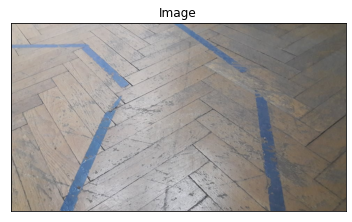

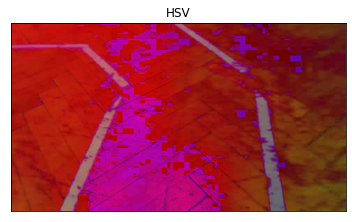

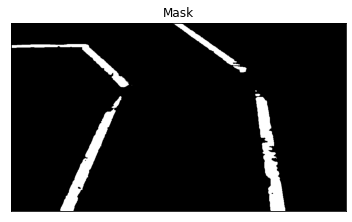

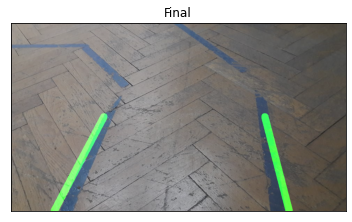

In [16]:
frameTest = cv2.imread("laneBlue4.jpg")
laneLines = detectLane(frameTest, lowerBlue, upperBlue)
laneLinesImage = displayLines(frameTest, laneLines)

showImageBGR(laneLinesImage, "Final")

# Motion Planning (Steering)

We need to compute the steering angle of the car, given the detected lane lines.

We get the middle line if we have two lanes and a parallel line if we have a single lane in the frame, then we compute the angle of the middle lane (steering angle) 

In [17]:
def computeSteeringAngle(frame, laneLines):
    """ Find the steering angle based on lane line coordinate
        We assume that camera is calibrated to point to dead center
    """
    if len(laneLines) == 0:
        logging.info('No lane lines detected, do nothing')
        return -90

    # Get middle line in case of detecting single lane
    height, width, _ = frame.shape
    if len(laneLines) == 1:
        logging.debug('Only detected one lane line, just follow it. %s' % lane_lines[0])
        x1, _, x2, _ = laneLines[0][0]
        x_offset = x2 - x1
    else:   # get middle line in case of detecting two lanes
        _, _, left_x2, _ = laneLines[0][0]
        _, _, right_x2, _ = laneLines[1][0]
        cameraMidOffsetPercent = 0.00 # 0.0 means car pointing to center, -0.03: car is centered to left, +0.03 means car pointing to right
        mid = int(width / 2 * (1 + cameraMidOffsetPercent))
        x_offset = (left_x2 + right_x2) / 2 - mid

    # find the steering angle, which is angle between navigation direction to end of center line
    y_offset = int(height / 2)

    angleToMidRadian = math.atan(x_offset / y_offset)  # angle (in radian) to center vertical line
    angleToMidDeg = int(angleToMidRadian * 180.0 / math.pi)  # angle (in degrees) to center vertical line
    steeringAngle = angleToMidDeg + 90  # this is the steering angle needed by picar front wheel

    logging.debug('new steering angle: %s' % steeringAngle)
    return steeringAngle

Stabilize the steering angle

In [18]:
def stabilizeSteeringAngle(currSteeringAngle, newSteeringAngle, numOfLaneLines, maxAngleDeviationTwoLines=5, maxAngleDeviationOneLane=1):
    """
    Using last steering angle to stabilize the steering angle
    This can be improved to use last N angles, etc
    if new angle is too different from current angle, only turn by maxAngleDeviation degrees
    """
    if numOfLaneLines == 2 :
        # if both lane lines detected, then we can deviate more
        maxAngleDeviation = maxAngleDeviationTwoLines
    else :
        # if only one lane detected, don't deviate too much
        maxAngleDeviation = maxAngleDeviationOneLane
    
    angleDeviation = newSteeringAngle - currSteeringAngle
    if abs(angleDeviation) > maxAngleDeviation:
        stabilizedSteeringAngle = int(currSteeringAngle + maxAngleDeviation * angleDeviation / abs(angleDeviation))
    else:
        stabilizedSteeringAngle = newSteeringAngle
    logging.info('Proposed angle: %s, stabilized angle: %s' % (newSteeringAngle, stabilizedSteeringAngle))
    return stabilizedSteeringAngle

In [19]:
def displayHeadingLine(frame, steeringAngle, lineColor=(0, 0, 255), lineWidth=15):
    headingImage = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1,y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right 
    steeringAngleRadian = steeringAngle / 180.0 * math.pi
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steeringAngleRadian))
    y2 = int(height / 2)

    cv2.line(headingImage, (x1, y1), (x2, y2), lineColor, lineWidth)
    headingImage = cv2.addWeighted(frame, 0.8, headingImage, 1, 1)

    return headingImage

Testing

Steering angle:  93


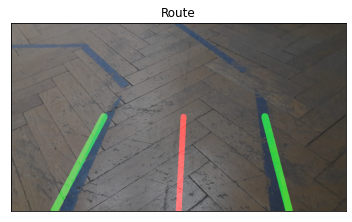

In [20]:
steeringAngle = computeSteeringAngle(frameTest, laneLines)
finalImage = displayHeadingLine(laneLinesImage, steeringAngle)

showImageBGR(finalImage, "Route")
print("Steering angle: ", steeringAngle)